## Import libraries

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [15]:
animal = 'SP148'
# output_folder =  '/home/sthitapati/Documents/sequence_data/seq_optoinhibition/output'
output_folder =  '/mnt/Data/analysis/seq_optoinhibition/output'

# file name

folder = os.path.join(output_folder, animal)
print(folder) 


/mnt/Data/analysis/seq_optoinhibition/output/SP148


In [16]:
# print contents of the folder
print('contents of the folder:')
for file in os.listdir(folder):
    print(file)

# load file with the name animal + _transition_data_all_sessions.csv

file_name = os.path.join(animal + '_transition_data_all_sessions.csv')
print(f'loading file ... {file_name}')

contents of the folder:
Preprocessed
SP148_transition_data_all_sessions.csv
loading file ... SP148_transition_data_all_sessions.csv


In [17]:
# load file_name as pandas dataframe
df = pd.read_csv(os.path.join(folder, file_name))
# df.head()

# print column names
print('column names:')
for col in df.columns:
    print(col)


column names:
Unnamed: 0
trial_id
transition_type
start_poke_port
end_poke_port
start_poke_in_timestamp
start_poke_out_timestamp
end_poke_in_timestamp
end_poke_out_timestamp
out_in_latency
in_in_latency
repeat_filter
2s_time_filter_out_in
2s_time_filter_in_in
opto_condition
opto_stimulated_port
training_level
led_intensities_ports_2_3_4_5
reward_amounts_ports_1_2_3_4
cumulative_trial_id
session_id
date
day
animal_id
group


In [18]:
# print all unique values in the column 'session_id'

print('unique values in the column session_id:')
print(df['session_id'].unique())

unique values in the column session_id:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [19]:
# state which sessions would you like to summarise
sessions_to_summarise = [33, 34, 35, 36, 37, 38, 39]

# create a new dataframe with only the sessions you want to summarise

df_s = df[df['session_id'].isin(sessions_to_summarise)]
# df_s.head()
# df_s['session_id'].unique()

df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32161 entries, 100130 to 132290
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     32161 non-null  int64  
 1   trial_id                       32161 non-null  int64  
 2   transition_type                32161 non-null  int64  
 3   start_poke_port                32161 non-null  int64  
 4   end_poke_port                  32161 non-null  int64  
 5   start_poke_in_timestamp        32161 non-null  float64
 6   start_poke_out_timestamp       32161 non-null  float64
 7   end_poke_in_timestamp          32161 non-null  float64
 8   end_poke_out_timestamp         32160 non-null  float64
 9   out_in_latency                 32161 non-null  float64
 10  in_in_latency                  32161 non-null  float64
 11  repeat_filter                  32161 non-null  int64  
 12  2s_time_filter_out_in          32161 non

## Accumulate the data into a single dataframe

In [20]:
def filter_dataframe(df, filter_sequence_from_start_port=False):
    """
    This function filters a given dataframe based on specific conditions and returns a new dataframe.
    """
    # List to store the updated rows
    filtered_rows = []

    # Loop through each unique animal_id
    for animal in df['animal_id'].unique():
        animal_df = df[df['animal_id'] == animal].copy()

        # Get all unique cumulative_trial_ids for the current animal and sort them
        unique_trial_ids = animal_df['cumulative_trial_id'].unique()
        unique_trial_ids.sort()

        for trial_id in unique_trial_ids:
            # Filter DataFrame for specific trial
            trial_df = animal_df[animal_df['cumulative_trial_id'] == trial_id].copy()

            # Find the index of first occurrence based on filter_sequence_from_start_port
            if filter_sequence_from_start_port:
                trial_start_index = trial_df[trial_df['start_poke_port'] == 2].index.min()
            else:
                trial_start_index = trial_df.index.min()

            # If there's no valid trial_start_index for the trial, just continue to the next trial
            if pd.isna(trial_start_index):
                continue

            # Filter rows that occur at or after the trial_start_index
            updated_trial_df = trial_df.loc[trial_start_index:].copy()

            # Set reference timestamp
            reference_timestamp = updated_trial_df.loc[trial_start_index, 'start_poke_in_timestamp']

            # Calculate latency to start trial
            latency_to_start_trial = reference_timestamp - trial_df['start_poke_in_timestamp'].iloc[0]

            # Update timestamp columns
            for timestamp_column in ['start_poke_in_timestamp', 'start_poke_out_timestamp', 
                                     'end_poke_in_timestamp', 'end_poke_out_timestamp']:
                updated_trial_df[timestamp_column] -= reference_timestamp

            # Calculate new in_in_latency and out_in_latency
            updated_trial_df['in_in_latency'] = updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_in_timestamp']
            updated_trial_df['out_in_latency'] = updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_out_timestamp']

            # Condense the updated trial DataFrame to one row
            condensed_row = updated_trial_df.iloc[0].copy()  # Make an explicit copy
            array_columns = ['transition_type', 'start_poke_port', 'end_poke_port', 
                            'start_poke_in_timestamp', 'start_poke_out_timestamp', 
                            'end_poke_in_timestamp', 'end_poke_out_timestamp', 
                            'out_in_latency', 'in_in_latency', 'repeat_filter', 
                            '2s_time_filter_out_in', '2s_time_filter_in_in', 
                            'training_level']
            for column in array_columns:
                condensed_row[column] = np.array(updated_trial_df[column])

            condensed_row['latency_to_start_trial'] = latency_to_start_trial
            condensed_row['opto_condition'] = updated_trial_df['opto_condition'].iloc[0] if condensed_row['opto_stimulated_port'] != np.nan else np.nan
            condensed_row['opto_stimulated_port'] = updated_trial_df['opto_stimulated_port'].iloc[0] if condensed_row['opto_stimulated_port'] != np.nan else np.nan

            # Append condensed row to the filtered DataFrame
            filtered_rows.append(condensed_row)


    # Convert list of rows to DataFrame
    filtered_df = pd.DataFrame(filtered_rows)

    # Reset index of the new DataFrame
    filtered_df.reset_index(drop=True, inplace=True)

    # Drop unnecessary columns
    filtered_df.drop(['led_intensities_ports_2_3_4_5', 'reward_amounts_ports_1_2_3_4'], axis=1, inplace=True)

    # # replace empty rows in opto_condition and opto_stimulated_port with NaN



    # Return the filtered DataFrame

    return filtered_df


In [21]:

filtered_df_s = filter_dataframe(df_s, filter_sequence_from_start_port=False)

## Summarise the number of non-stimulated and stimulated trials

In [22]:
# print in a nice format the counts of trials for each unique value in the column 'opto_stimulated_port'
# e.g. number of trials with opto_stimulated_port = 1: 10
#      number of trials with opto_stimulated_port = 2: 20
#      number of trials with opto_stimulated_port = nan: 30
# Assuming filtered_df_s is your DataFrame and 'opto_stimulated_port' is the column of interest.

print(f'summarizing opto-stimulation of {len(sessions_to_summarise)} sessions: {sessions_to_summarise}', end='\n\n')

# Count of non-stimulated (NaN) trials
non_stimulated_count = filtered_df_s['opto_stimulated_port'].isna().sum()
print('number of non-stimulated trials:', non_stimulated_count)

# Count of trials for each unique value in 'opto_stimulated_port'
value_counts = filtered_df_s['opto_stimulated_port'].value_counts(dropna=False)
for port in range(1, 5):
    print(f'number of trials with opto_stimulated_port = {port}:', value_counts.get(port, 0))

summarizing opto-stimulation of 7 sessions: [33, 34, 35, 36, 37, 38, 39]

number of non-stimulated trials: 3224
number of trials with opto_stimulated_port = 1: 155
number of trials with opto_stimulated_port = 2: 173
number of trials with opto_stimulated_port = 3: 152
number of trials with opto_stimulated_port = 4: 145


## Prepare the dataframe for plotting and summarising out_in_latency and port_in_times
the data is to be segragate into 5 groups: non-stimulated, port_1, port_2, port_3, port_4

In [23]:

# get out_in_latency and in_in_latency from df_s 

df_latency = df_s[['out_in_latency', 'in_in_latency', 'opto_stimulated_port', 'repeat_filter']].copy()

# add a column port_time = in_in_latency - out_in_latency
df_latency['port_time'] = df_latency['in_in_latency'] - df_latency['out_in_latency']

# reset index
df_latency.reset_index(drop=True, inplace=True)

df_latency.head()

# to simplify calculation of variable delay, we will only consider trials with port_time < 1 second
df_latency = df_latency[df_latency['port_time'] < 1]

# and remove trials with out_in_latency > 5 seconds to account for very long wait time before the next poke when the animal just decides to go have a mid-strength beer
df_latency = df_latency[df_latency['out_in_latency'] < 5]

# remove rows when there is repat of poke in the same port (repeat_filter = 0)

df_latency = df_latency[df_latency['repeat_filter'] == 1]


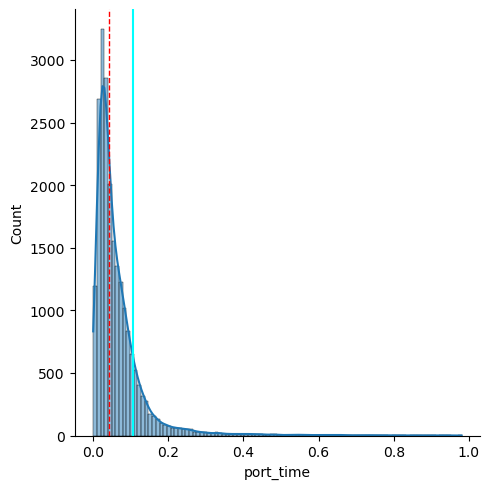

Vertical cyan line, 95th percentile of port_time: 0.17922000000002083
Vertical red line, median of port_time: 0.04330000000004483


In [24]:
# plot the distribution of df_latency['port_time'] 

sns.displot(df_latency['port_time'], bins=100, kde=True)

# draw a vertical line at the 75th percentile in the same plot

plt.axvline(x=np.percentile(df_latency['port_time'],85), color='cyan')
plt.axvline(x=np.median(df_latency['port_time']), color='red', linestyle='--', linewidth=1)
plt.show()

print('Vertical cyan line, 95th percentile of port_time:', np.percentile(df_latency['port_time'],95))
print('Vertical red line, median of port_time:', np.median(df_latency['port_time']))

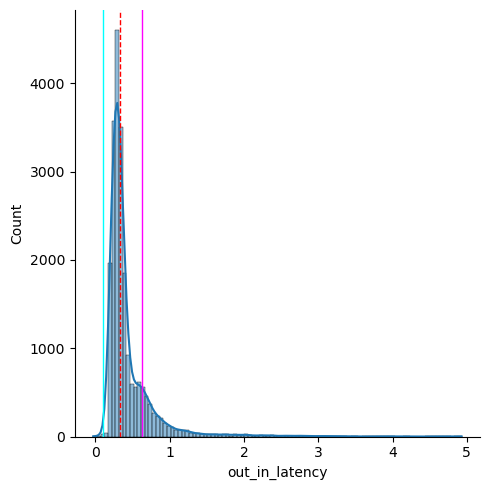

Vertical magenta line, 85th percentile of out_in_latency: 0.6315600000002631
Vertical red line, median of out_in_latency: 0.3254000000001724
Vertical cyan line, 85th percentile of port_time: 0.17922000000002083


In [25]:
# plot a histogram of df_latency['out_in_latency'] 

sns.displot(df_latency['out_in_latency'], bins=100, kde=True)

# draw a vertical line at the 75th percentile in the same plot

plt.axvline(x=np.percentile(df_latency['out_in_latency'],85), color='magenta', linewidth=1)
plt.axvline(x=np.median(df_latency['out_in_latency']), color='red', linestyle='--', linewidth=1)
# draw a cyan line at the 85th percentile of df_latency['port_time'] in the same plot
plt.axvline(x=np.percentile(df_latency['port_time'],85), color='cyan', linewidth=1)
plt.show()

print('Vertical magenta line, 85th percentile of out_in_latency:', np.percentile(df_latency['out_in_latency'],85))
print('Vertical red line, median of out_in_latency:', np.median(df_latency['out_in_latency']))
print('Vertical cyan line, 85th percentile of port_time:', np.percentile(df_latency['port_time'],95))

# plot

In [26]:
# lowerBound = np.percentile(df_latency['port_time'],95
# upperBound = np.percentile(df_latency['out_in_latency'],85
# mean_ = np.mean(df_latency['out_in_latency'])
# sd_ = np.std(df_latency['out_in_latency'])

print('mean of out_in_latency:', round(np.mean(df_latency['out_in_latency']), 2))
print('standard deviation of out_in_latency:', round(np.std(df_latency['out_in_latency']), 2))
print('lower bound of port_time:', round(np.percentile(df_latency['port_time'], 95), 2))
print('upper bound of out_in_latency:', round(np.percentile(df_latency['out_in_latency'], 85), 2))


mean of out_in_latency: 0.44
standard deviation of out_in_latency: 0.37
lower bound of port_time: 0.18
upper bound of out_in_latency: 0.63


## Summarise variable delay trials